# Building a Movie Recommendation Engine with Factorization Machines

## 1. Preprocessing

### 1.1 Load data from parquet directories in saved to S3:

##### After (1) converting the raw CSV files to Parquet using Glue and (2) performing some basic transformations with Athena, the new parquet files were saved to S3.

In [1]:
import boto3
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
import s3fs


BUCKET = 'movie-recommendation-engine-project'


def get_dataframe_from_parquet_parquet_directory(parquet_directory):
    s3_resource = boto3.resource('s3')
    bucket = s3_resource.Bucket(BUCKET)
    s3_file_system = s3fs.S3FileSystem()
    df = pd.DataFrame()
    for object_summary in bucket.objects.filter(Prefix=parquet_directory):
        new_df = pq.read_table(f"s3://{BUCKET}/{object_summary.key}", filesystem=s3_file_system).to_pandas()
        df = pd.concat([df, new_df])
    return df
        

In [2]:
df_movie_genre = get_dataframe_from_parquet_parquet_directory("data_transformations/movie_genre/")
df_movie_genre

,movieid,genreid
0,4603,16
1,4603,6
2,4605,10
3,4605,6
4,4608,9
...,...,...
14559,178827,4
14560,178827,3
14561,178827,5
14562,178827,6


In [3]:
df_user_rating = get_dataframe_from_parquet_parquet_directory("data_transformations/ratings_ordered/")
df_user_rating

,userid,movieid,rating,timestamp
0,1,804,4.0,964980499
1,1,1210,5.0,964980499
2,1,2018,5.0,964980523
3,1,2826,4.0,964980523
4,1,2628,4.0,964980523
...,...,...,...,...
100831,610,101739,3.5,1495959269
100832,610,70,4.0,1495959282
100833,610,328,3.5,1495959299
100834,610,2459,3.5,1495959405


In [4]:
df_movie_tag = get_dataframe_from_parquet_parquet_directory("data_transformations/tags_cleaned/")
df_movie_tag

,userid,movieid,tag,tagid,timestamp
0,62,410,family,180,1525636708
1,62,2124,family,180,1525636855
2,62,2953,family,180,1525636883
3,62,27808,family,180,1525554919
4,62,34150,sexy female scientist,445,1525554144
...,...,...,...,...,...
2753,599,2959,complicated,120,1498456923
2754,599,2959,mindfuck,320,1498456912
2755,599,2959,quirky,396,1498456918
2756,599,2959,satirical,429,1498456920


### 1.2 Leave out movie tags from features

#### We decide to leave out tags since there are far fewer tagged movies than movies that aren't tagged.

In [8]:
len(df_movie_tag["movieid"].unique())

1343

In [9]:
len(df_user_rating["movieid"].unique())

9724

### 1.3 Normalize ratings and determine binary classification scheme


#### We notice that the user_ratings are not uniformly distributed. In fact, the distribution is quite odd, apparently on account of the tendency for users to prefer rounding to whole numbers instead of assigning decimal ratings.

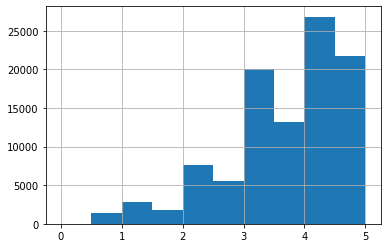

In [10]:
df_user_rating["rating"].hist(bins=np.linspace(0, 5, 11))

#### We normalize the ratings by subtracting the average rating and dividng by the standard deviation of ratings.

In [11]:
rating_mean = np.mean(df_user_rating["rating"])
rating_std = np.std(df_user_rating["rating"])
ratings_normalized = [(row["rating"] - rating_mean) / rating_std for index, row in df_user_rating.iterrows()]
df_user_rating["rating_normalized"] = pd.Series(ratings_normalized)

#### Now, dividing the data in binary classes of "recommended" or "not recommended" will be as simple as assigning positive (or zero) normalized ratings to the former and negative normalized ratings to the latter. 

### 1.4 Shuffle data

In [7]:
df_user_rating = df_user_rating.sample(frac=1).reset_index(drop=True)

### 1.5 Get a dictionary that will allow look-up of the genre assignments for a given movie, which will allow us to add genre features to our data, which is explained in 1.7

In [5]:
from collections import defaultdict, Counter

movie_id_to_genre_ids_dict = defaultdict(list)

for index, row in df_movie_genre.iterrows():
    movie_id_to_genre_ids_dict[row["movieid"]].append(row["genreid"])
    
movie_id_to_genre_ids_counter_dict = {}

for key, value in movie_id_to_genre_ids_dict.items():
    movie_id_to_genre_ids_counter_dict[key] = Counter(value)
    

In [6]:
user_ids = sorted(list(set(df_user_rating["userid"])))
movie_ids = sorted(list(set(df_user_rating["movieid"])))
tag_ids = sorted(list(set(df_movie_tag["tagid"])))
genre_ids = sorted(list(set(df_movie_genre["genreid"])))

num_users = len(user_ids)
num_movies = len(movie_ids)
num_tags = len(tag_ids)
num_genres = len(genre_ids)
num_ratings = len(df_user_rating)

### 1.6 We notice that the movie ID numbers in the user ratings dataframe have gaps, such that the max number is not the same as the number of distinct IDs. To simplify the one-hot encoding of movies using movie ID, we transform movie IDs such that this previous condition holds.

In [12]:
movie_id_to_proper_index_dict = {movie_id: i+1 for i, movie_id in enumerate(sorted(np.unique(df_user_rating["movieid"]))) } 

### 1.7 We progressively build the sparse matrix that will be used to train the factorization machines algorithm. 

#### For each row of X, from left to right we add: 
#### (1) a one-hot encoding of the user
#### (2) a one-hot encoding of the movie
#### (3) the genre features for the movie, where the values of each genre feature is equal to the number of times the genre was assigned to that movie divided by the number of genre assignments to that movie. 

#### Note: the genre features sum to one. This scheme (3) was inspired by a similar one in the original paper: https://www.csie.ntu.edu.tw/~b97053/paper/Rendle2010FM.pdf

#### Y is the labels vector, where 1 means "recommended" and 0 means "not recommended". The intuition here is that a rating that is higher than the mean rating should be better, and one lower should be worse. 

In [13]:
from scipy.sparse import lil_matrix

def get_X_Y(df, X, Y):
    for index, row in df.iterrows():
        X[index, int(row["userid"]) - 1] = 1 # user information
        X[index, num_users + int(movie_id_to_proper_index_dict[row["movieid"]]) - 1] = 1 # movie information

        # movie genre features
        if movie_id_to_genre_ids_counter_dict.get(int(row["movieid"]), False):
            genre_ids_counter = movie_id_to_genre_ids_counter_dict[int(row["movieid"])]
            num_genres_for_movie = sum(genre_ids_counter.values())
            for genre_id, count in genre_ids_counter.items():
                X[index, num_users + num_movies + int(genre_id) - 1] = float(count / num_genres_for_movie)

        # label
        if row["rating_normalized"] >= 0.0:
            Y.append(1)
        else:
            Y.append(0)
    
    Y = np.array(Y).astype('float32')
        
    return X, Y

def get_dataset(validation_fraction=0.15, test_fraction=0.15):
    m_validation = int(num_ratings*validation_fraction)
    m_test = int(num_ratings*test_fraction)
    m_train = num_ratings - m_validation - m_test
    n = num_users + num_movies + num_genres
    
    df_train = df_user_rating[:m_train].reset_index()
    df_validation = df_user_rating[m_train:m_train+m_validation].reset_index()
    df_test = df_user_rating[m_train+m_validation:].reset_index()
    
    X_train = lil_matrix((m_train, n)).astype('float32') # one-hot encoded sparse matrix
    X_validation = lil_matrix((m_validation, n)).astype('float32')
    X_test = lil_matrix((m_test, n)).astype('float32')

    Y_train = [] # labels vector
    Y_validation = []
    Y_test = []
    
    X_train, Y_train = get_X_Y(df_train, X_train, Y_train)
    X_validation, Y_validation = get_X_Y(df_validation, X_validation, Y_validation)
    X_test, Y_test = get_X_Y(df_test, X_test, Y_test)
    
    return X_train, X_validation, X_test, Y_train, Y_validation, Y_test

#### We obtain a split dataset of train data (70%), validation data (15%), and test data (15%).

In [14]:
X_train, X_validation, X_test, Y_train, Y_validation, Y_test = get_dataset()

### 1.8 Save dataset to S3 in necessary format for training SageMaker factorization machines algorithm (protobuf)

In [15]:
import sagemaker.amazon.common as smac
import io

prefix = "fm_input"

key_train = f"{prefix}/train.protobuf"
key_validation = f"{prefix}/validation.protobuf"
key_test = f"{prefix}/test.protobuf"

def write_to_s3_as_protobuf(X, Y, bucket, key):
    buffer = io.BytesIO()
    smac.write_spmatrix_to_sparse_tensor(buffer, X, Y)
    buffer.seek(0)
    boto3.resource("s3").Bucket(bucket).Object(key).upload_fileobj(buffer)
    return f"s3://{bucket}/{key}"
    
train_data = write_to_s3_as_protobuf(X_train, Y_train, BUCKET, key_train)
print(f"Uploaded train data to: {train_data}")

validation_data  = write_to_s3_as_protobuf(X_validation, Y_validation, BUCKET, key_validation)    
print(f"Uploaded validation data to: {validation_data}")

test_data  = write_to_s3_as_protobuf(X_test, Y_test, BUCKET, key_test)    
print(f"Uploaded train data to: {test_data}")

Uploaded train data to: s3://movie-recommendation-engine-project/fm_input/train.protobuf
Uploaded validation data to: s3://movie-recommendation-engine-project/fm_input/validation.protobuf
Uploaded train data to: s3://movie-recommendation-engine-project/fm_input/test.protobuf


## 2. Training + Model Deployment 

### 2.1 Get factorization machines algorithm container from corresponding image

In [16]:
from sagemaker.amazon.amazon_estimator import get_image_uri

container = get_image_uri(boto3.Session().region_name, 'factorization-machines')

The method get_image_uri has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


### 2.2 Train model + Hyperparameter tuning

#### We tune the hyperparameters of minibatch size and epochs using logarithmic scales, using Bayesian search.

#### We use validation data for validation

In [24]:
import sagemaker
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner

sess = sagemaker.Session()

role = sagemaker.get_execution_role()

output_path = f"s3://{BUCKET}/fm_output"

feature_dim = num_users + num_movies + num_genres

fm = sagemaker.estimator.Estimator(container,
                                   role, 
                                   train_instance_count=1, 
                                   train_instance_type='ml.c5.xlarge',
                                   output_path=output_path,
                                   sagemaker_session=sess)

fm.set_hyperparameters(feature_dim=feature_dim,
                       num_factors=128,
                       predictor_type='binary_classifier')


hyperparameter_ranges = {
    'mini_batch_size': IntegerParameter(1, 2048, scaling_type="Logarithmic"),
    'epochs': IntegerParameter(1, 100, scaling_type="Logarithmic")
}
tuner = HyperparameterTuner(
    fm,
    objective_metric_name='test:binary_classification_accuracy',
    objective_type='Maximize',
    hyperparameter_ranges=hyperparameter_ranges,
    max_jobs=40,
    max_parallel_jobs=10,
    strategy='Bayesian'
)

tuner.fit({'train': train_data, 'test': validation_data})

train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


.....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................____s

Job ended with status 'Stopped' rather than 'Completed'. This could mean the job timed out or stopped early for some other reason: Consider checking whether it completed as you expect.


### 2.3 Visualize hyperparameter tuning job results

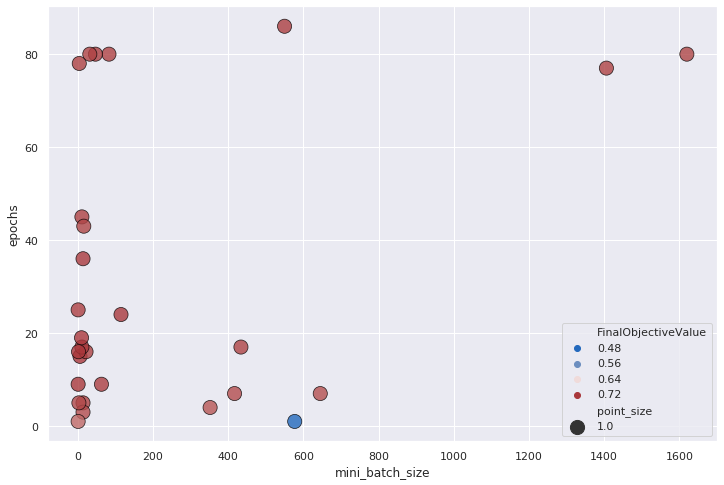

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(rc={'figure.figsize':(12,8)})

df_tuner = sagemaker.HyperparameterTuningJobAnalytics(tuner.latest_tuning_job.job_name).dataframe()
df_tuner["point_size"] = pd.Series([1.0 for i in range(len(df_tuner))])
sns.scatterplot(data=df_tuner, x="mini_batch_size", y="epochs", hue="FinalObjectiveValue", palette="vlag", alpha=0.8, size="point_size", sizes=(200,200), edgeColor="Black")


### 2.4 Deploy best model from hyperparameter tuning job to start making predictions

In [27]:
import json
from sagemaker.deserializers import JSONDeserializer
from sagemaker.serializers import JSONSerializer

class FMSerializer(JSONSerializer):
    def serialize(self, data):
        js = {'instances': []}
        for row in data:
              js['instances'].append({'features': row.tolist()})
        return json.dumps(js)

predictor = tuner.deploy(
    initial_instance_count=1,
    instance_type='ml.c5.xlarge',
    serializer=FMSerializer(),
    deserializer= JSONDeserializer()
)



2021-01-23 03:14:10 Starting - Preparing the instances for training
2021-01-23 03:14:10 Downloading - Downloading input data
2021-01-23 03:14:10 Training - Training image download completed. Training in progress.
2021-01-23 03:14:10 Uploading - Uploading generated training model
2021-01-23 03:14:10 Completed - Training job completed
-------------!

## 3. Model Evaluation

### 3.1 Compare a random prediction with corresponding actual value

In [35]:
i = 10000

prediction = predictor.predict(X_test[i, :].toarray())['predictions'][0]['predicted_label']

print(f"Predicted: {prediction}")
print(f"Actual: {Y_test[i]}")


Predicted: 1.0
Actual: 1.0


### 3.2 Get predictions for entire test set

In [41]:
Y_predicted = []
num_test = X_test.shape[0]
for i in range(num_test):
    for array in np.array_split(X_test[i].toarray(), 1):
        result = predictor.predict(array)
        Y_predicted += [r["predicted_label"] for r in result['predictions']]

Y_predicted = np.array(Y_predicted)

### 3.3 Compute evaluation metrics for test set predictions

In [46]:
from sklearn.metrics import accuracy_score, confusion_matrix

accuracy_score(Y_test, Y_predicted)

0.7112066115702479

In [48]:
confusion_matrix(Y_test, Y_predicted)

array([[5790, 1937],
       [2431, 4967]])